In [1511]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from statsmodels.discrete.discrete_model import Probit
import matplotlib.pyplot as plt
import random

# Functions

In [1098]:
def prob_to_rec(recession_probabilities_array, prob_threshold):
    
    array = np.where(recession_probabilities_array > prob_threshold, 1, 0)
    return array

In [1099]:
def get_numpy_data(dataframe, features, label):
    features_matrix = dataframe[features].to_numpy()
    label_array = dataframe[label].to_numpy()
    return(features_matrix, label_array)

In [1065]:
def logistic_regression(x_train, x_test, y_train, y_test, penalty, max_iter, C):
    
    logistic_model = linear_model.LogisticRegression(penalty = penalty, max_iter = max_iter, C = C)
    trained_model = logistic_model.fit(x_train, y_train)
    
    training_set_prob = trained_model.predict_proba(x_train)
    test_set_prob = trained_model.predict_proba(x_test)
    

# Data Import

In [1485]:
recession_data = pd.read_csv("recession_data.csv")
recession_data = recession_data.drop(["Unnamed: 0", "year_month", "rec_prob", "nber_rec", "one_half_year_rec", "three_month_bond_equivalent"], axis = 1)

features_list = recession_data.columns.to_list()
features_list.remove("one_year_rec")
recession_label = "one_year_rec"

In [1525]:
# Finalizing the Recession Data
recession_data = pd.read_csv("updated_final_data.csv")
recession_data = recession_data.drop(["Unnamed: 0", "date", "final_vol", "usrecd", "tcu", "cpiaucsl_x", "fedfunds", "indpro", "civpart", "unrate", "umcsent", "mich", "m1sl", "icsa", "m2sl", "m2v", "mabmm301usm189s", "bogmbase", "adj close", "volume"], axis = 1)
recession_data["spread_derivative"] = pd.to_numeric(recession_data["spread_derivative"], errors = "coerce")
recession_data.replace([np.inf, -np.inf], np.nan, inplace=True)
recession_data = recession_data.dropna()

# Create the feature list and target label
features_list = recession_data.columns.to_list()
features_list.remove("custom_recession_data")

recession_label = "custom_recession_data"

In [1526]:
recession_data

,dff,t10y3m,spread_derivative,spread_change_momentun,custom_recession_data,cycle_indicator
0,12.90,2.24,-0.034483,-1.0,1.0,0.192771
1,12.12,2.43,0.084821,1.0,1.0,0.245042
2,12.37,2.46,0.012346,2.0,1.0,0.246853
3,12.12,2.50,0.016260,3.0,1.0,0.190524
4,12.12,2.50,0.000000,0.0,1.0,0.184375
...,...,...,...,...,...,...
14342,4.33,-0.86,0.162162,4.0,0.0,-0.039073
14343,4.33,-0.95,0.104651,5.0,0.0,-0.042297
14344,4.33,-1.12,0.178947,6.0,0.0,-0.053005
14345,4.33,-1.12,0.000000,0.0,0.0,-0.053005


In [1468]:
np.sum(recession_data.loc[:,"one_year_rec"])

188

In [1352]:
no_recession_index = recession_data[recession_data["custom_recession_data"] == 0].index
yes_recession_index = recession_data[recession_data["custom_recession_data"] == 1].index

random_no_recession_index = random.sample(no_recession_index.to_list(), 1000)
random_yes_recession_index = random.sample(yes_recession_index.to_list(), 1000)
final_recession_index = random_no_recession_index + random_yes_recession_index

ValueError: Sample larger than population or is negative

In [1129]:
len(yes_recession_index)

2047

In [1130]:
final_recession_index

[7367,
 8514,
 5614,
 4059,
 2215,
 1867,
 5414,
 10154,
 12825,
 5956,
 11375,
 5392,
 7120,
 5972,
 5049,
 4643,
 12341,
 1591,
 8252,
 13012,
 8359,
 14304,
 5855,
 2783,
 12406,
 14151,
 5328,
 3426,
 4721,
 5759,
 1466,
 6058,
 2219,
 2730,
 14320,
 7333,
 10244,
 1787,
 8402,
 3762,
 9895,
 11002,
 8297,
 2368,
 4587,
 3618,
 11083,
 11254,
 12372,
 8279,
 12552,
 7002,
 1710,
 9660,
 5906,
 4811,
 6114,
 13607,
 6204,
 4847,
 10944,
 1259,
 9905,
 1812,
 822,
 2739,
 10466,
 7803,
 6039,
 10070,
 11725,
 7734,
 3626,
 3476,
 3872,
 11910,
 13484,
 385,
 5884,
 8112,
 4129,
 1681,
 13440,
 835,
 2002,
 492,
 13660,
 13696,
 6316,
 12639,
 10861,
 7682,
 13988,
 4926,
 6025,
 13158,
 411,
 5682,
 7823,
 6322,
 10686,
 5315,
 1029,
 5197,
 3922,
 5368,
 2417,
 4391,
 5280,
 3877,
 1185,
 8040,
 1690,
 519,
 750,
 1959,
 12967,
 900,
 3764,
 4911,
 2808,
 7320,
 11102,
 8711,
 4858,
 5504,
 12717,
 2610,
 2635,
 8417,
 320,
 2604,
 641,
 1344,
 12338,
 10607,
 13138,
 5037,
 14127,


In [1390]:
recession_data = recession_data.loc[final_recession_index,:]

KeyError: '[7367, 8514, 5614, 4059, 2215, 1867, 5414, 10154, 12825, 5956, 11375, 5392, 7120, 5972, 5049, 4643, 12341, 1591, 8252, 13012, 8359, 14304, 5855, 2783, 12406, 14151, 5328, 3426, 4721, 5759, 1466, 6058, 2219, 2730, 14320, 7333, 10244, 1787, 8402, 3762, 9895, 11002, 8297, 2368, 4587, 3618, 11083, 11254, 12372, 8279, 12552, 7002, 1710, 9660, 5906, 4811, 6114, 13607, 6204, 4847, 10944, 1259, 9905, 1812, 822, 2739, 10466, 7803, 6039, 10070, 11725, 7734, 3626, 3476, 3872, 11910, 13484, 5884, 8112, 4129, 1681, 13440, 835, 2002, 492, 13660, 13696, 6316, 12639, 10861, 7682, 13988, 4926, 6025, 13158, 5682, 7823, 6322, 10686, 5315, 1029, 5197, 3922, 5368, 2417, 4391, 5280, 3877, 1185, 8040, 1690, 519, 750, 1959, 12967, 900, 3764, 4911, 2808, 7320, 11102, 8711, 4858, 5504, 12717, 2610, 2635, 8417, 2604, 641, 1344, 12338, 10607, 13138, 5037, 14127, 7565, 3761, 13857, 1190, 3412, 3706, 10454, 3838, 8538, 13764, 12377, 1076, 4961, 5620, 10987, 6232, 1760, 6540, 748, 6073, 7949, 11376, 5357, 3298, 10377, 2391, 5434, 7044, 12603, 14146, 7632, 4731, 9958, 4513, 5433, 11247, 5541, 10702, 10968, 12834, 7365, 4056, 9961, 10724, 11770, 11849, 2021, 10326, 1084, 11233, 2514, 13769, 1407, 547, 11113, 11523, 14129, 2579, 2800, 11643, 13501, 4122, 11278, 8648, 1977, 2251, 1881, 6208, 4801, 5011, 13421, 6309, 8082, 7476, 5826, 7954, 12859, 4331, 5331, 4908, 10194, 8113, 1143, 14337, 3614, 14159, 11801, 9801, 4461, 8388, 1260, 2123, 3632, 12541, 649, 7643, 7480, 4930, 2148, 8397, 12078, 3467, 13772, 3969, 7765, 1390, 5893, 5946, 12167, 8511, 10696, 8293, 13595, 4877, 4101, 10156, 10235, 4816, 7299, 7366, 3466, 11584, 4663, 863, 10108, 10029, 13476, 2436, 11944, 5755, 727, 4910, 8658, 8846, 3345, 8595, 695, 7463, 10449, 10903, 5213, 6291, 8249, 6365, 1229, 13530, 4986, 4921, 11444, 5555, 12810, 2705, 3889, 9684, 12051, 13643, 778, 1150, 1059, 491, 5309, 3331, 14265, 3256, 12770, 3771, 784, 3289, 5650, 1219, 13852, 8152, 5610, 5691, 610, 7071, 2330, 5010, 2104, 11241, 6523, 2453, 4324, 5270, 8115, 1471, 7176, 598, 1604, 8917, 11031, 12041, 3548, 5120, 12148, 3278, 8503, 2645, 11660, 12509, 9926, 3945, 12862, 10750, 8109, 3391, 6026, 12746, 6048, 10669, 11779, 12258, 1269, 9650, 13536, 5254, 6193, 7743, 3425, 13855, 8691, 9718, 11620, 10915, 12088, 12878, 8615, 9638, 7944, 6077, 10886, 4433, 11594, 6037, 12793, 13031, 5295, 13447, 3269, 3459, 14246, 4342, 13553, 917, 2583, 5954, 5208, 8008, 5522, 10982, 13912, 4874, 5816, 13437, 511, 664, 2714, 5246, 4606, 3844, 6266, 6023, 1749, 8197, 1129, 10109, 8643, 10739, 3236, 4607, 2029, 3360, 10017, 11513, 10529, 594, 3436, 4744, 6441, 4929, 14172, 1785, 6212, 5071, 3608, 11184, 10169, 1704, 8422, 12561, 838, 756, 10592, 1101, 10304, 752, 5811, 10321, 13606, 5288, 2210, 7008, 12482, 10285, 13641, 11773, 1845, 12089, 4529, 13759, 4824, 5411, 13579, 5499, 5651, 12404, 5207, 7180, 6009, 6250, 4995, 2009, 12120, 2692, 8815, 7434, 7889, 9957, 4475, 10606, 14388, 9771, 3746, 498, 13978, 12262, 1624, 5727, 14134, 625, 12083, 11407, 10119, 4175, 1660, 4886, 2294, 2489, 10310, 2444, 2060, 7490, 12885, 4974, 7649, 2412, 8081, 8867, 2784, 9677, 4048, 7157, 1405, 4236, 3960, 1964, 6385, 3432, 6016, 6157, 14116, 6490, 9694, 2427, 11321, 1235, 5495, 12376, 4628, 4390, 5575, 3814, 7047, 13864, 11109, 2321, 7179, 3504, 8392, 7282, 5056, 11425, 2607, 4263, 12157, 2126, 7024, 3813, 8700, 6384, 2547, 966, 11330, 10924, 1636, 13131, 14077, 3573, 11906, 10478, 12429, 8576, 8145, 13760, 11362, 3794, 13659, 7832, 12954, 6507, 6522, 3300, 10240, 13767, 4564, 11393, 10625, 10413, 8123, 684, 5640, 10046, 1662, 8458, 8712, 6018, 11762, 2066, 11610, 999, 2313, 2263, 14113, 10314, 10551, 5809, 4114, 12860, 13014, 3733, 2407, 8418, 5425, 941, 7194, 4597, 4962, 488, 8233, 12192, 10184, 1429, 11306, 12545, 11573, 1754, 7755, 12243, 3565, 10550, 4953, 7136, 9687, 13625, 14344, 14041, 7531, 4660, 12979, 6414, 4545, 9618, 2405, 588, 5410, 2708, 4958, 12759, 9693, 5291, 7078, 8884, 11882, 768, 7156, 12222, 13727, 4735, 8067, 7492, 14382, 6410, 10720, 10913, 4026, 4557, 14107, 5743, 4884, 9712, 13575, 4542, 4049, 2305, 1066, 4713, 2178, 10778, 3437, 7426, 3309, 4440, 3832, 5515, 4603, 12536, 2598, 12923, 6184, 11717, 7942, 2534, 11808, 10054, 13976, 7702, 6209, 8360, 3802, 4115, 1633, 5999, 14141, 8352, 13175, 10101, 10732, 13458, 10762, 1968, 8452, 5531, 8831, 7440, 11348, 13615, 4686, 7060, 12591, 12595, 3247, 2289, 2722, 10055, 10879, 10278, 12190, 12832, 12790, 13655, 6422, 3642, 13001, 7542, 4761, 12512, 7726, 553, 11458, 8500, 12508, 13590, 12864, 8243, 2460, 2525, 7094, 10118, 4900, 4823, 1028, 4229, 13866, 3516, 2727, 8634, 12343, 7721, 3697, 8216, 5584, 4001, 4626, 8329, 7487, 6154, 2446, 7033, 2080, 6083, 2564, 5786, 894, 4480, 10197, 10111, 7985, 13651, 7735, 4414, 8596, 11918, 7200, 8621, 8241, 1597, 5836, 10571, 8323, 14189, 14364, 7609, 5314, 6111, 9989, 638, 1805, 4629, 1879, 6333, 13762, 11590, 4285, 5909, 9858, 13446, 12324, 7672, 11418, 11552, 8327, 7201, 655, 11915, 9760, 12510, 1915, 11396, 10296, 2166, 6962, 692, 13916, 10136, 4394, 7987, 11179, 5479, 13974, 11485, 10576, 8713, 4664, 5679, 10263, 5211, 8030, 10222, 4369, 13923, 5124, 10473, 5993, 9825, 10504, 7979, 1445, 8581, 3807, 12102, 10350, 10712, 1283, 4401, 13903, 10559, 14342, 13870, 12774, 3522, 12996, 1687, 1615, 1738, 10401, 2481, 11443, 3414, 5194, 10993, 13807, 7929, 12199, 1172, 6148, 10329, 3907, 6224, 7225, 3707, 14033, 3630, 11166, 3588, 10043, 4901, 5275, 4486, 11653, 7860, 10220, 1676, 11257, 4372, 8610, 13148, 13883, 1287, 9807, 9972, 3263, 2503, 14185, 4336, 11215, 4389, 11148, 7438, 3337, 6960, 7549, 8130, 8194, 8322, 7388, 12460, 592, 13975, 10385, 12411, 10496, 14327, 14169, 3537, 7011, 3268, 11548, 12942, 7298, 2796, 11682, 13616, 11087, 11104, 13492, 10601, 1483, 5131, 8636, 11103, 9862, 2099, 14324, 14070, 10435, 955, 3719, 7284, 10324, 13586, 841, 11868, 1095, 5278, 8401, 6019, 14095, 1851, 5217, 3668, 12072, 5702, 5158, 10701, 5387, 2188, 7717, 5667, 10275, 1940, 3497, 11964, 2674, 5950, 3282, 8477, 3550, 2140, 7075, 10233, 7058, 11547, 8488, 1368, 952, 7007, 12096, 10335, 8836, 10393, 4386, 3709, 11088, 10692, 10742, 7104, 2738, 12405, 4368, 4134, 2360, 788, 10376, 6999, 6515, 10068, 13067, 7407, 11683, 8218, 7165, 11131, 6582, 6677, 13379, 3190, 2917, 2854, 6566, 9047, 3209, 2970, 6837, 9585, 6852, 2873, 2981, 6672, 9021, 6683, 3224, 13373, 9449, 9297, 9117, 9054, 6651, 6726, 3123, 3020, 9109, 9569, 9505, 6711, 3179, 3138, 9596, 6629, 9595, 2978, 6669, 9015, 9321, 9386, 13277, 9198, 3050, 9267, 9602, 3111, 6936, 3182, 13312, 13190, 6752, 13276, 6842, 9462, 3015, 8955, 2872, 6591, 13240, 9531, 9576, 2961, 9316, 3112, 13293, 9521, 2848, 9364, 6636, 9479, 6764, 6745, 9550, 6780, 9233, 13381, 9314, 9242, 9543, 9592, 6724, 3129, 9424, 9128, 9388, 3168, 9167, 6746, 6863, 9444, 9115, 3178, 6680, 6695, 13337, 13186, 3063, 9124, 6886, 9220, 6588, 9368, 6558, 13396, 13391, 9212, 6787, 2876, 6789, 2887, 13320, 6668, 9570, 3055, 6890, 6585, 9193, 9068, 13228, 2845, 6612, 6583, 8923, 3180, 9530, 13202, 6751, 9355, 8944, 8965, 6817, 13221, 9448, 13214, 9320, 6665, 6688, 13187, 13382, 6768, 9131, 9107, 6873, 6786, 3088, 9482, 6596, 9197, 9041, 9529, 9384, 9520, 3069, 9489, 13375, 9594, 6841, 13389, 6697, 9138, 9423, 6839, 3008, 9181, 9183, 3041, 9148, 6771, 13403, 9226, 13308, 9549, 9083, 2852, 9254, 8972, 3006, 2977, 8942, 9168, 9516, 6653, 13209, 13252, 6686, 9609, 3210, 2931, 2968, 9155, 3013, 2960, 6798, 9185, 13330, 9565, 9415, 9014, 9002, 8988, 6827, 6626, 2926, 6743, 3030, 13181, 2991, 3094, 9063, 9610, 13297, 6657, 9191, 9562, 3132, 3064, 9468, 9472, 6656, 2901, 6927, 9397, 6690, 6790, 9043, 6833, 13355, 9144, 9378, 13204, 6608, 6781, 3062, 8997, 9577, 13316, 8929, 6684, 9460, 2956, 13400, 8996, 9016, 13298, 3202, 6737, 2851, 9150, 9591, 6602, 9525, 6804, 6744, 2979, 9149, 13350, 6784, 9160, 6638, 9508, 13327, 13329, 6808, 9400, 9051, 6698, 9075, 9497, 6937, 6678, 3046, 3095, 9017, 9325, 2859, 8932, 2831, 13182, 13290, 8984, 3060, 6604, 6897, 3155, 3186, 13394, 6721, 6579, 9553, 9542, 6617, 9608, 6877, 9515, 9405, 9517, 13357, 9105, 6826, 8948, 6832, 9190, 9512, 9572, 3007, 6613, 9491, 13393, 6685, 9537, 6630, 8985, 3102, 9477, 9522, 8993, 9369, 3073, 3195, 9464, 8987, 9484, 6903, 13205, 3039, 6704, 9013, 6918, 6917, 8961, 6928, 9548, 13253, 9045, 2987, 6755, 9096, 6901, 6563, 3071, 9338, 6625, 6659, 9262, 6603, 13200, 13405, 13367, 6851, 6912, 2824, 6671, 6681, 6941, 2911, 13378, 6667, 6715, 9056, 13353, 9189, 9573, 8946, 8931, 6758, 13251, 2950, 6620, 9236, 9103, 6782, 3162, 6905, 9269, 9110, 13335, 9486, 9561, 3173, 9245, 6762, 6853, 13198, 9500, 9483, 13223, 6956, 3223, 9536, 13183, 9159, 9259, 2853, 13230, 2930, 2878, 2906, 6911, 6908, 8994, 13271, 2973, 6719, 6560, 9116, 9092, 6812, 6619, 3125, 3045, 13309, 3051, 9461, 8920, 6676, 2919, 13218, 2896, 9250, 9007, 13380, 2866, 6847, 13336, 6589, 9273, 9433, 3170, 8935, 6875, 2864, 6742, 6864, 9214, 3119, 2993, 6953, 13377, 8986, 2994, 3032, 9432, 9395, 9547, 9281, 9022, 13303, 9060, 6562, 6601, 9104, 9401, 9343, 6879, 2929, 13390, 9490, 9129, 9540, 13294, 9278, 2927, 9114, 3208, 6708, 2897, 8975, 9453, 9120, 9095, 6577, 6703, 6701, 3079, 13398, 3197, 6611, 6854, 9492, 3225, 3017, 9157, 6687, 6722, 6887, 6942, 6802, 2857, 9495, 3096, 3009, 2935, 9130, 9551, 6923, 6725, 9440, 9008, 6586, 6951, 9407, 9552, 6893, 3185, 9246, 9001, 9280, 3199, 9356, 13208, 9437, 2867, 9311, 2915, 6648, 2921, 13342, 13273, 9165, 6627, 6730, 3169, 2860, 3118, 9527, 9391, 6569, 6838, 8970, 8940, 9390, 13407, 9533, 3130, 2948, 9344, 2830, 9123, 3043, 6642, 3031, 8991, 9326, 9255, 9252, 9480, 9351, 9145, 9442, 13215, 6915, 9589, 3042, 9541, 8983, 13314, 9136, 6763, 2967, 6674, 3047, 13264, 9266, 6872, 6840, 9050, 9082, 6810, 9474, 8980, 13332, 6783, 9436, 9089, 6594, 6584, 9179, 6857, 6925, 9327, 6634, 2964, 2868, 9373, 6606, 13292, 13369, 13387, 9459, 13334, 9232, 3004, 9133, 6843, 3078, 9428, 3033, 6916, 9081, 2992, 13302, 9009, 3222, 6904, 9557, 9498, 9435, 9061, 6950, 9006, 6610, 9035, 3134, 9034, 6880, 6739, 2850, 9488, 6662, 2843, 6797, 6776, 3022, 3146, 6757, 2832, 6946, 9612, 9406, 9346, 9361, 6830, 6813, 9102, 13225, 13339, 9481, 9195, 2903, 3012, 6720, 9230, 9291, 2835, 13354, 6766, 2990, 3207, 9112, 2965, 3052, 6660, 9518, 6570, 8941, 9247, 9049, 9502, 9113, 9471, 9071, 9227, 6736, 13188, 13363, 3196, 2957, 3021, 13399, 3011, 2975, 9287, 3082, 9074, 6590, 13282, 8918, 6935, 9036, 9375, 3136, 9039, 6658, 2953, 8982, 13217, 3120, 9476, 6615, 9475, 9611, 6723, 3034, 13284, 6949, 13358, 6741, 9240, 9604, 9538, 9235, 9535, 2884, 6940, 6663, 13306, 3061, 9335, 8978, 3201, 13257, 3139, 8990, 3211, 6740, 3189, 13361, 2910, 13347, 6820, 6575, 2883, 3024, 9260, 9469, 9345, 13231, 9005, 6834, 6666, 9192, 9366, 13238, 6693, 9019, 9037, 6828, 9485, 9286, 8974, 13261, 2837, 3184, 9156, 6865, 3044, 3204, 13179, 6578, 9414, 9582, 3087, 9221, 9606, 2828, 2989, 9434, 3198, 9416, 9204, 6710, 3106, 13365, 3027, 13283, 9011, 9154, 6778, 6754, 9024, 3154, 2838, 6738, 9244, 9501, 9371, 6689, 6624, 2934, 13285, 9452, 9053, 2847, 6870, 13241, 2983, 13227, 13319, 9601, 9546, 9171, 3187, 6732, 9593, 9298, 3074, 8950, 9211, 9354, 3000, 9293, 9507, 9300, 8962, 9560, 3048, 9143, 6691, 3081, 8977, 6593, 8957, 3191, 2869, 9020, 6706, 3161, 3093, 6943, 6947, 9523, 13189, 9377, 13265, 9032, 9614, 6712, 3143, 2914, 13255, 9362, 9086, 13307, 3153, 13386, 13267, 6934, 2894, 6859, 3158, 3109, 9334, 9152, 8951, 9200] not in index'

In [1527]:
# Create the Numpy feature matrix and recession label
features_matrix, label_array = get_numpy_data(recession_data, features_list, recession_label)

In [1528]:
# Create the train-test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(features_matrix, label_array, test_size = 0.3, random_state = 11)

In [1529]:
# Standardrize the each features
scale = preprocessing.StandardScaler().fit(x_train)
x_train = scale.transform(x_train)

# Logistic Regression with L2 Penalty

In [1535]:
# Build the Logistic Regression
log_reg = linear_model.LogisticRegression(solver = "liblinear", penalty = "l2",  C = 0.001, max_iter = 10000)
rec_logistic = log_reg.fit(x_train, y_train)
training_prob = rec_logistic.predict_proba(x_test)
test_pred = rec_logistic.predict(x_test)

In [1531]:
rec_logistic.coef_

array([[ 0.28917508, -0.12500988,  0.00487177,  0.04598261, -0.44436638]])

In [1532]:
p = training_prob[:, 1]

In [1533]:
p

array([0.59520893, 0.6258308 , 0.61522477, ..., 0.57644515, 0.76936674,
       0.37293121])

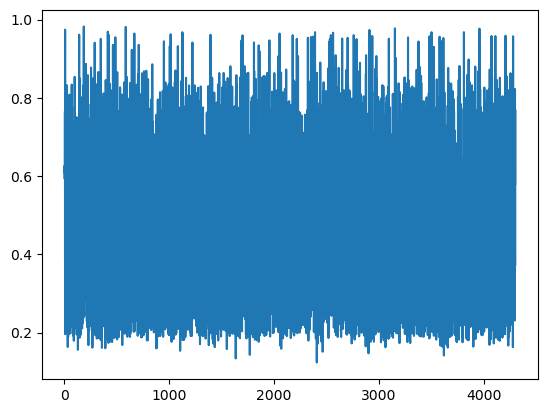

In [1534]:
plt.plot(p)

In [1536]:
test_rec = prob_to_rec(training_prob, 0.633333)[:,1]

In [1537]:
test_rec

array([0, 0, 0, ..., 0, 1, 0])

In [1538]:
np.count_nonzero(test_rec == y_test)/len(y_test)

0.7191350848639851

In [1380]:
np.sum(label_array)/len(label_array)

0.19166666666666668

# Tree Method & Gradient Boosting

In [1539]:
decision_tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 4, splitter = "best")
rec_decison_tree = decision_tree.fit(x_train, y_train)

In [1540]:
rec_decison_tree.get_n_leaves()

14

[Text(0.58, 0.9, 'x[4] <= -0.533\ngini = 0.309\nsamples = 10033\nvalue = [8115, 1918]'),
 Text(0.32, 0.7, 'x[0] <= 0.727\ngini = 0.481\nsamples = 3361\nvalue = [2012, 1349]'),
 Text(0.16, 0.5, 'x[1] <= -1.4\ngini = 0.422\nsamples = 2664\nvalue = [1858, 806]'),
 Text(0.08, 0.3, 'x[0] <= -0.326\ngini = 0.493\nsamples = 641\nvalue = [283, 358]'),
 Text(0.04, 0.1, 'gini = 0.096\nsamples = 197\nvalue = [10, 187]'),
 Text(0.12, 0.1, 'gini = 0.474\nsamples = 444\nvalue = [273, 171]'),
 Text(0.24, 0.3, 'x[1] <= 0.571\ngini = 0.345\nsamples = 2023\nvalue = [1575, 448]'),
 Text(0.2, 0.1, 'gini = 0.292\nsamples = 1912\nvalue = [1573, 339]'),
 Text(0.28, 0.1, 'gini = 0.035\nsamples = 111\nvalue = [2, 109]'),
 Text(0.48, 0.5, 'x[0] <= 1.58\ngini = 0.344\nsamples = 697\nvalue = [154, 543]'),
 Text(0.4, 0.3, 'x[1] <= 0.567\ngini = 0.101\nsamples = 525\nvalue = [28, 497]'),
 Text(0.36, 0.1, 'gini = 0.057\nsamples = 512\nvalue = [15, 497]'),
 Text(0.44, 0.1, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]')

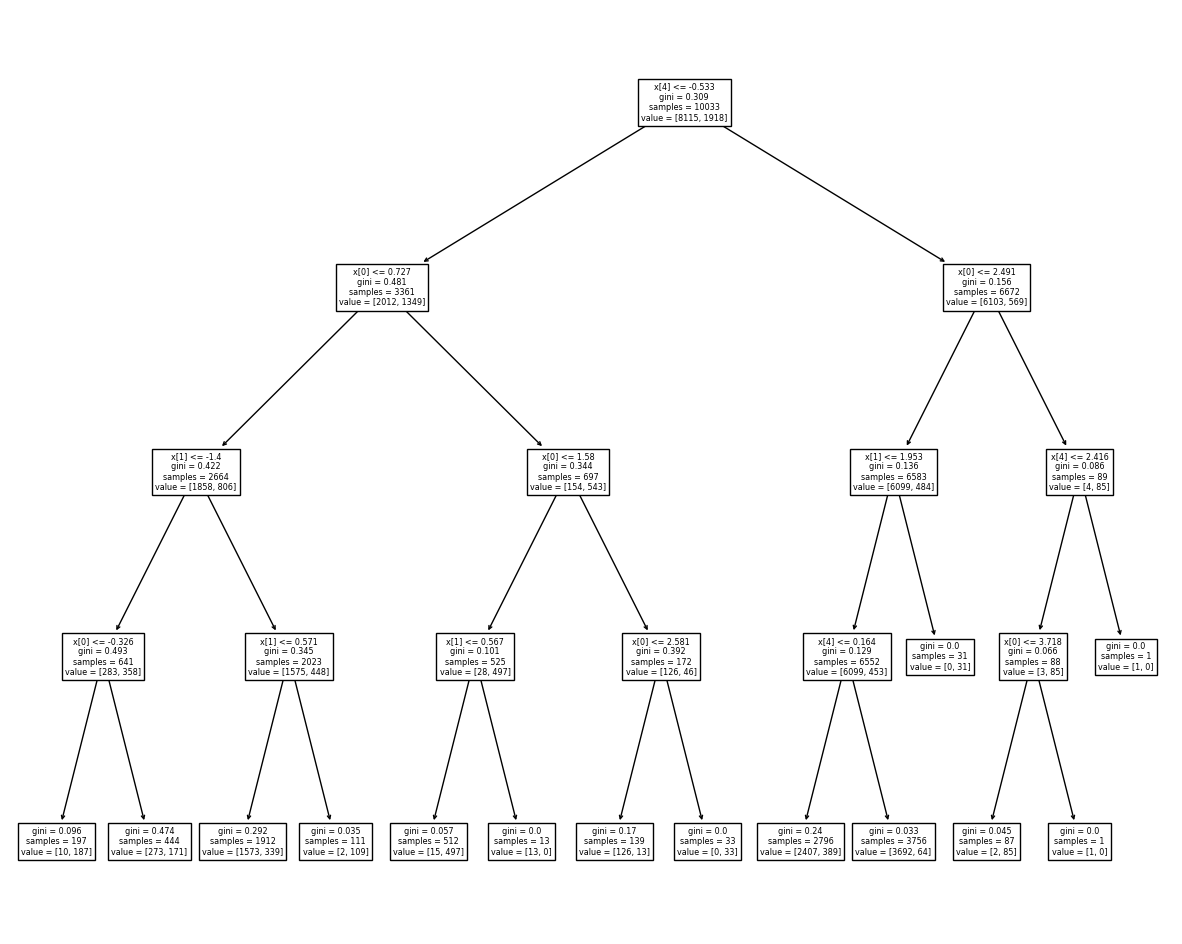

In [1541]:
plt.figure(figsize = (15,12))
tree.plot_tree(rec_decison_tree)

In [1542]:
training_prob = rec_decison_tree.predict_proba(x_train)
test_prob = rec_decison_tree.predict_proba(x_test)

In [1543]:
train_rec = prob_to_rec(training_prob, 0.633333)[:,1]
test_rec = prob_to_rec(test_prob, 0.633333)[:,1]

In [1544]:
train_correct = np.count_nonzero(train_rec == y_train)/len(y_train)
test_correct = np.count_nonzero(test_rec == y_test)/len(y_test)
print("traing set: " + str(train_correct))
print("test set: " + str(test_correct))

traing set: 0.8998305591547892
test set: 0.5905603348058591
